# RAG para Chatbot de Suporte em E-commerce de Moda

Este notebook implementa uma pipeline de Recuperação com Geração (Retrieval-Augmented Generation – RAG) utilizando um modelo de linguagem fine-tunado em Português do Brasil para o domínio de moda. A solução cria um catálogo simulado, indexa documentos com embeddings, recupera os k documentos mais relevantes via FAISS e gera respostas com o modelo carregado.

Objetivo e visão geral da pipeline
- Mock de dados de produtos e políticas em SQLite, com nomes de produtos realistas e atributos úteis (categoria, material, preço, estoque e medidas por tamanho).
- Embeddings e índice de busca com FAISS para recuperação semântica eficiente (top‑k direto do índice).
- Geração com o modelo Qwen, instruído a não expor identificadores internos (como SKUs) e a responder somente com base no contexto.
- Avaliação de recuperação (Recall@k, MRR@k, NDCG@k) e de geração (BERTScore-F1, similaridade por embeddings).

Como a pipeline atinge o objetivo
- Precisão na recuperação: embeddings + FAISS (top‑k) garantem documentos semanticamente próximos como contexto para geração.
- Segurança e foco no usuário: instruções explícitas evitam vazar identificadores internos e guiam respostas objetivas e elegantes.
- Medição e melhoria contínua: métricas padronizadas ajudam a detectar lacunas e orientar ajustes (por exemplo, tuning de k e prompts).

Execução em GPU no Google Colab (T4 x A100) e uso de 2 GPUs
- Seleção de GPU: em Colab, menu “Ambiente de execução” > “Alterar tipo de ambiente de execução” > “Acelerador de hardware: GPU”. T4 é suficiente para este notebook, A100 oferece maior throughput e permite batches maiores e prompts mais longos.
- Recomendações práticas:
  - T4: mantenha batch size moderado nas embeddings (por exemplo, 64–128), top‑k pequeno (3–5) e snippets curtos (≈400 caracteres). Use precisão mista (fp16) para geração.
  - A100: permita batch size maior (128–256), candidatos m mais altos (10–20) e contexto um pouco maior; considere bf16 se disponível.
- Comparação prática T4 x A100 neste notebook:
  - Rode integralmente as seções de embeddings, recuperação, geração e avaliação em cada GPU.
  - Registre: tempo total, throughput (consultas/s), pico de memória na geração e qualidade (Recall@k, MRR@k, NDCG@k, BERTScore-F1).
  - A A100 deve mostrar menor tempo, maior throughput e permitir aumentar k sem Out Of Memory (OOM); a qualidade pode subir levemente com reranker e contexto um pouco maior.

## 1. Setup do Ambiente (Google Colab)

Esta seção prepara o ambiente para execução no Colab.

- Instala bibliotecas necessárias: `transformers`, `accelerate`, `faiss-cpu` (ou `faiss-gpu` se disponível), `sentence-transformers`, `datasets`, `umap-learn`, `scikit-learn`, `matplotlib`, `seaborn`, `plotly`, `evaluate`, `bert-score` (opcional).
- Verifica e exibe a GPU atual (T4 ou A100).
- Monta Google Drive se necessário (para carregar o modelo `.pkl`).


In [ ]:
#@title Instalação de dependências
%%bash
pip -q install -U transformers accelerate peft datasets sentence-transformers faiss-cpu umap-learn scikit-learn matplotlib seaborn plotly evaluate bert-score
python - <<'PY'
import torch, platform
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
print('Python:', platform.python_version())
PY


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
Python: 3.12.11


In [ ]:
#@title Montar Google Drive (se necessário)
from google.colab import drive
mount_drive = True  #@param {type:"boolean"}
if mount_drive:
    drive.mount('/content/drive')

MODEL_PKL_PATH = "/content/drive/Shareddrives/nsync_m11/sprint3/qwen_fine_tuned.pkl"  #@param {type:"string"}
SYSTEM_PREFIX = "Você é uma consultora de moda brasileira. Responda de forma clara, objetiva e elegante."

import os, gc, json, math, random
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


Mounted at /content/drive


'cuda'

## 2. Carregamento do Modelo e Justificativa

Utilizamos o modelo Qwen/Qwen2.5-0.5B, leve e eficiente para Colab, com fine-tuning em PT-BR e adapters LoRA já mesclados. Esse tamanho favorece latência e custo baixos para POCs e PMEs.

O modelo foi salvo em `.pkl`. A seguir, carregamos o objeto contendo o modelo e/ou seus pesos e estruturas associadas (tokenizer, config). Caso o `.pkl` contenha apenas state_dict, reconstrói-se a arquitetura e carrega-se os pesos.


In [ ]:
#@title Carregar modelo Qwen fine-tunado (.pkl)
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM

BASE_MODEL = "Qwen/Qwen2.5-0.5B"

def load_qwen_from_pkl(pkl_path: str):
    obj = None
    with open(pkl_path, 'rb') as f:
        obj = pickle.load(f)
    if isinstance(obj, dict):
        # Pode conter chaves como 'state_dict', 'config', 'tokenizer_name'
        state_dict = obj.get('state_dict')
        config_name = obj.get('config_name', BASE_MODEL)
        tokenizer_name = obj.get('tokenizer_name', BASE_MODEL)
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(config_name)
        if state_dict is not None:
            model.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()
        return model, tokenizer
    else:
        # Caso o .pkl seja o modelo serializado diretamente (torch.nn.Module)
        model = obj
        tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        model.to(device)
        model.eval()
        return model, tokenizer

model, tokenizer = load_qwen_from_pkl(MODEL_PKL_PATH)
model.__class__.__name__, tokenizer.__class__.__name__


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

('Qwen2ForCausalLM', 'Qwen2TokenizerFast')

## 3. Mock da Base de Dados (Produtos e Políticas)

Criaremos um catálogo com ~1.500 produtos de moda (nome, descrição, categoria, preço, estoque por tamanho, medidas por tamanho, materiais, cores, marca) e documentos de políticas (troca/devolução, frete, prazos, privacidade). Esses dados serão usados como corpus para o RAG. Salvaremos também cópias em CSV/JSONL para reuso.


In [ ]:
#@title Gerar catálogo de produtos e políticas (mock) em SQLite com nomes adjetivados
import pandas as pd
import numpy as np
import random, sqlite3, json
from uuid import uuid4

NUM_PRODUCTS = 1500  # conforme alinhado
random.seed(SEED)
np.random.seed(SEED)

CATEGORIES = [
    'camiseta', 'camisa', 'calça', 'jeans', 'short', 'saia', 'vestido',
    'blazer', 'jaqueta', 'moletom', 'cardigan', 'blusa', 'regata', 'macacão'
]
SIZES = ['PP', 'P', 'M', 'G', 'GG']
ADJECTIVES = ['básica', 'slim', 'oversized', 'acinturada', 'fluida', 'estruturada', 'leve', 'aberta', 'alongada']
MATERIALS = ['algodão', 'viscose', 'poliéster', 'linho', 'seda', 'jeans', 'malha']
BRANDS = ['Ateliê Atlântica', 'Serra & Mar', 'Luna Moda', 'Rio Norte', 'Aquarela']
COLORS = ['preto', 'branco', 'azul', 'vermelho', 'verde', 'bege', 'cinza', 'rosa']

products = []
for i in range(NUM_PRODUCTS):
    category = random.choice(CATEGORIES)
    adj = random.choice(ADJECTIVES)
    brand = random.choice(BRANDS)
    material = random.choice(MATERIALS)
    color = random.choice(COLORS)
    name = f"{category} {adj}"
    price = round(random.uniform(59.9, 799.9), 2)
    base_desc = (
        f"{category} {adj} da marca {brand}, confeccionada em {material}, "
        f"com design versátil para o dia a dia. Cor predominante: {color}."
    )
    stock = {size: random.randint(0, 40) for size in SIZES}
    measures = {
        size: {
            'peito_cm': round(random.uniform(80, 110), 1),
            'cintura_cm': round(random.uniform(60, 100), 1),
            'quadril_cm': round(random.uniform(86, 120), 1),
            'comprimento_cm': round(random.uniform(50, 120), 1),
        } for size in SIZES
    }
    sku = str(uuid4())[:8].upper()
    products.append({
        'sku': sku,
        'nome': name,
        'descricao': base_desc,
        'categoria': category,
        'preco': price,
        'cor': color,
        'marca': brand,
        'material': material,
        'estoque': stock,
        'medidas': measures,
    })

df_products = pd.DataFrame(products)

policies = [
    {
        'titulo': 'Política de Troca e Devolução',
        'conteudo': (
            'Aceitamos trocas em até 30 dias e devoluções em até 7 dias após o recebimento. '
            'Produtos devem estar sem uso, com etiqueta e embalagem original. '
            'Itens em promoção podem ter condições diferenciadas.'
        )
    },
    {
        'titulo': 'Prazo de Entrega e Frete',
        'conteudo': (
            'O prazo de entrega varia conforme região e modalidade selecionada. '
            'Frete grátis a partir de R$ 299 para Sul e Sudeste. '
            'Rastreamento é enviado por e-mail após despacho.'
        )
    },
    {
        'titulo': 'Guia de Medidas',
        'conteudo': (
            'As medidas variam por modelagem. Recomendamos conferir peito, cintura, quadril '
            'e comprimento em relação às tabelas por tamanho (PP, P, M, G, GG).'
        )
    },
    {
        'titulo': 'Política de Privacidade',
        'conteudo': (
            'Seus dados são tratados conforme a LGPD, utilizados apenas para processamento de pedidos '
            'e comunicação autorizada.'
        )
    },
]

df_policies = pd.DataFrame(policies)

# Persistência em SQLite
out_dir = '/content/drive/Shareddrives/nsync_m11/sprint3/mock_data'
os.makedirs(out_dir, exist_ok=True)
DB_PATH = f'{out_dir}/catalogo.db'
conn = sqlite3.connect(DB_PATH)

df_products.drop(columns=['estoque','medidas']).to_sql('products', conn, if_exists='replace', index=False)
df_policies.to_sql('policies', conn, if_exists='replace', index=False)

# Tabelas normalizadas auxiliares (estoque e medidas por tamanho)
rows_stock = []
rows_measures = []
for _, r in df_products.iterrows():
    for size, qty in r['estoque'].items():
        rows_stock.append({'sku': r['sku'], 'size': size, 'qty': int(qty)})
    for size, m in r['medidas'].items():
        rows_measures.append({
            'sku': r['sku'], 'size': size,
            'peito_cm': m['peito_cm'], 'cintura_cm': m['cintura_cm'],
            'quadril_cm': m['quadril_cm'], 'comprimento_cm': m['comprimento_cm']
        })

pd.DataFrame(rows_stock).to_sql('stock', conn, if_exists='replace', index=False)
pd.DataFrame(rows_measures).to_sql('measures', conn, if_exists='replace', index=False)

conn.commit()
conn.close()

DB_PATH, len(df_products), len(df_policies)


('/content/mock_data/catalogo.db', 1500, 4)

In [ ]:
#@title Preparar corpus de recuperação (produtos + políticas) a partir do SQLite
from typing import Iterable
import sqlite3

# Reabra o banco para leitura
conn = sqlite3.connect(DB_PATH)
df_products = pd.read_sql_query('SELECT * FROM products', conn)
df_policies = pd.read_sql_query('SELECT * FROM policies', conn)
df_stock = pd.read_sql_query('SELECT * FROM stock', conn)
df_measures = pd.read_sql_query('SELECT * FROM measures', conn)
conn.close()

# Reconstrói dicts de estoque e medidas
stock_map = df_stock.groupby('sku').apply(lambda g: {r['size']: int(r['qty']) for _, r in g.iterrows()}).to_dict()
measures_map = df_measures.groupby('sku').apply(lambda g: {
    r['size']:{'peito_cm':r['peito_cm'],'cintura_cm':r['cintura_cm'],'quadril_cm':r['quadril_cm'],'comprimento_cm':r['comprimento_cm']} for _, r in g.iterrows()
}).to_dict()

def product_to_doc(row: pd.Series) -> Dict:
    estoque = stock_map.get(row['sku'], {})
    medidas = measures_map.get(row['sku'], {})
    estoque_str = ', '.join([f"{k}:{v}" for k, v in estoque.items()])
    medidas_str = ', '.join([
        f"{size}(peito:{m['peito_cm']}cm, cintura:{m['cintura_cm']}cm, quadril:{m['quadril_cm']}cm, comp:{m['comprimento_cm']}cm)"
        for size, m in medidas.items()
    ])
    text = (
        f"SKU: {row['sku']} | Nome: {row['nome']} | Categoria: {row['categoria']} | Marca: {row['marca']} | Cor: {row['cor']} | Material: {row['material']} | "
        f"Preço: R$ {row['preco']} | Estoque: {estoque_str} | Medidas: {medidas_str} | Descrição: {row['descricao']}"
    )
    return {
        'id': row['sku'],
        'type': 'produto',
        'text': text,
        'meta': {
            'sku': row['sku'], 'categoria': row['categoria'], 'marca': row['marca'], 'cor': row['cor']
        }
    }


def policy_to_doc(row: pd.Series) -> Dict:
    return {
        'id': f"policy-{row.name}",
        'type': 'politica',
        'text': f"{row['titulo']}: {row['conteudo']}",
        'meta': {'titulo': row['titulo']}
    }

product_docs = [product_to_doc(r) for _, r in df_products.iterrows()]
policy_docs = [policy_to_doc(r) for _, r in df_policies.iterrows()]
corpus = product_docs + policy_docs
len(corpus), corpus[0]['text'][:180]


/tmp/ipython-input-96974926.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stock_map = df_stock.groupby('sku').apply(lambda g: {r['size']: int(r['qty']) for _, r in g.iterrows()}).to_dict()
/tmp/ipython-input-96974926.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  measures_map = df_measures.groupby('sku').apply(lambda g: {


(1504,
 'SKU: 7280C4C4 | Nome: cardigan slim | Categoria: cardigan | Marca: Ateliê Atlântica | Cor: verde | Material: jeans | Preço: R$ 241.12 | Estoque: PP:8, P:6, M:34, G:5, GG:37 | Medid')

## 3.1 Sanity checks do catálogo

Estatísticas para validar a integridade dos dados: contagem por categoria, preço por categoria, disponibilidade por tamanho e cobertura de medidas.


In [ ]:
#@title Sanity checks do catálogo
import sqlite3
conn = sqlite3.connect(DB_PATH)

# Contagem por categoria
cnt_cat = pd.read_sql_query('SELECT categoria, COUNT(*) as n FROM products GROUP BY categoria ORDER BY n DESC', conn)
# Estatísticas de preço
stats_preco = pd.read_sql_query('SELECT categoria, AVG(preco) as preco_medio, MIN(preco) as preco_min, MAX(preco) as preco_max FROM products GROUP BY categoria', conn)
# Disponibilidade total por tamanho
disp_tam = pd.read_sql_query('SELECT size, SUM(qty) as total FROM stock GROUP BY size ORDER BY size', conn)
# Cobertura de medidas por tamanho (contagem de SKUs com medidas registradas)
cob_med = pd.read_sql_query('SELECT size, COUNT(DISTINCT sku) as skus_com_medida FROM measures GROUP BY size ORDER BY size', conn)

conn.close()

cnt_cat, stats_preco.head(), disp_tam, cob_med


(   categoria    n
 0      short  123
 1   camiseta  119
 2    moletom  118
 3    vestido  114
 4   cardigan  110
 5     camisa  108
 6     regata  106
 7      blusa  105
 8     blazer  103
 9      jeans  102
 10     calça  102
 11   jaqueta  101
 12      saia   98
 13   macacão   91,
   categoria  preco_medio  preco_min  preco_max
 0    blazer   429.172136      62.11     799.23
 1     blusa   420.501429      86.07     787.29
 2     calça   423.331078      62.99     795.00
 3    camisa   410.450833      66.31     790.75
 4  camiseta   421.405714      61.57     794.28,
   size  total
 0    G  29407
 1   GG  30420
 2    M  29715
 3    P  30421
 4   PP  30231,
   size  skus_com_medida
 0    G             1500
 1   GG             1500
 2    M             1500
 3    P             1500
 4   PP             1500)

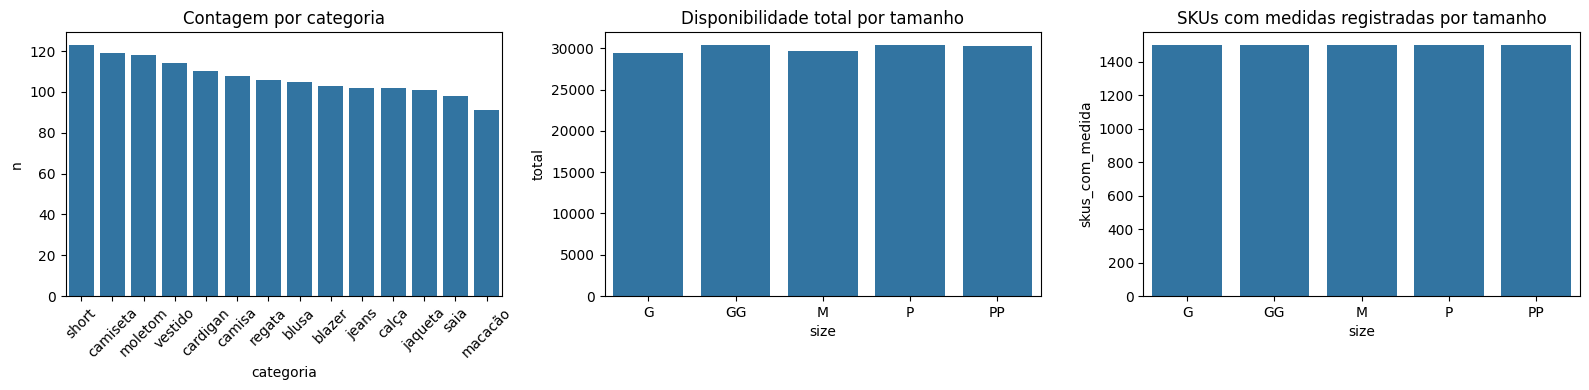

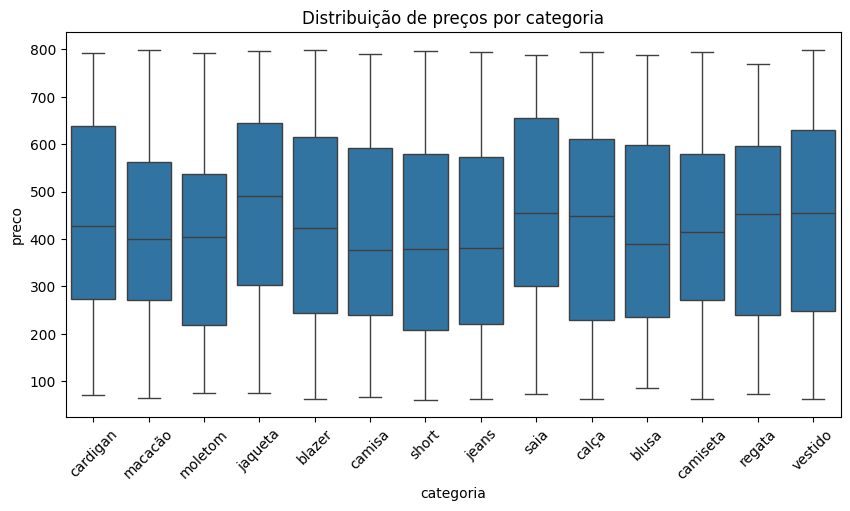

In [ ]:
#@title Visualizações dos sanity checks
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.barplot(data=cnt_cat, x='categoria', y='n', ax=axes[0])
axes[0].set_title('Contagem por categoria')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=disp_tam, x='size', y='total', ax=axes[1])
axes[1].set_title('Disponibilidade total por tamanho')

sns.barplot(data=cob_med, x='size', y='skus_com_medida', ax=axes[2])
axes[2].set_title('SKUs com medidas registradas por tamanho')
plt.tight_layout()
plt.show()

# Boxplot de preços por categoria
plt.figure(figsize=(10,5))
sns.boxplot(data=df_products, x='categoria', y='preco')
plt.title('Distribuição de preços por categoria')
plt.xticks(rotation=45)
plt.show()


## 4. Embeddings e Índice Vetorial (FAISS)

- O modelo de embeddings `intfloat/multilingual-e5-base` transforma textos em vetores numéricos que preservam similaridade semântica em Português do Brasil. Isso permite recuperar documentos relevantes mesmo quando as palavras não coincidem exatamente.
- Criamos um índice FAISS (Facebook AI Similarity Search) com produto interno normalizado para buscas rápidas. Para catálogos pequenos/médios, o índice plano (Flat) é suficiente; para catálogos grandes, estruturas hierárquicas (por exemplo, HNSW) reduzem latência com pequena perda de exatidão.
- A normalização de vetores alinha a métrica do índice com a similaridade de cosseno, tornando as pontuações comparáveis.


In [ ]:
#@title Gerar embeddings e criar índice FAISS
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

EMB_MODEL = 'intfloat/multilingual-e5-base'  # PT-BR amigável
BATCH_SIZE = 128

# E5 espera prefixos; para busca semântica, recomenda-se 'passage:' para docs e 'query:' para consultas

def normalize(a: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(a, axis=1, keepdims=True) + 1e-10
    return a / norms

# Reutilizar um único modelo de embeddings na GPU
try:
    embed_model
except NameError:
    embed_model = SentenceTransformer(EMB_MODEL, device=device)

@torch.inference_mode()
def compute_embeddings(texts):
    embs = embed_model.encode([f'passage: {t}' for t in texts],
                              batch_size=BATCH_SIZE,
                              show_progress_bar=True,
                              convert_to_numpy=True,
                              normalize_embeddings=False)
    return normalize(embs)

texts = [d['text'] for d in corpus]
# Limpeza preventiva do cache CUDA antes de operação pesada
if torch.cuda.is_available():
    torch.cuda.empty_cache()

embs = compute_embeddings(texts)

index = faiss.IndexFlatIP(embs.shape[1])
index.add(embs)
index.ntotal


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

1504

In [ ]:
#@title Funções de busca e recuperação (FAISS top-k)
from typing import List, Tuple

@torch.inference_mode()
def encode_queries(queries: List[str]) -> np.ndarray:
    # Reutiliza embed_model já inicializado no device atual
    q_embs = embed_model.encode([f'query: {q}' for q in queries],
                                batch_size=min(64, BATCH_SIZE),
                                show_progress_bar=False,
                                convert_to_numpy=True,
                                normalize_embeddings=False)
    return normalize(q_embs)

@torch.inference_mode()
def search_top_k(query: str, k: int = 5) -> List[Tuple[int, float]]:
    q = encode_queries([query])
    scores, idxs = index.search(q, k)
    return list(zip(idxs[0].tolist(), scores[0].tolist()))

# Limpa cache antes de um teste rápido (não obrigatório, mas seguro)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Teste rápido
top = search_top_k('Tenho 1,65m de altura, qual tamanho do vestido blazer?', k=5)
[(i, round(s, 3), corpus[i]['type']) for i, s in top]


[(784, 0.872, 'produto'),
 (725, 0.87, 'produto'),
 (1016, 0.87, 'produto'),
 (456, 0.869, 'produto'),
 (1201, 0.869, 'produto')]

## 5. Pipeline RAG e Template de Prompt

- Recupera top-k documentos relevantes.
- Concatena contexto em um prompt com instruções do sistema.
- Gera resposta com o Qwen, orientando a citar SKU ou política quando aplicável e evitar alucinações.


In [ ]:
#@title Implementação do RAG (geração)
from transformers import TextIteratorStreamer
from threading import Thread

MAX_NEW_TOKENS = 256
TOP_K = 5


def build_context(docs):
    blocks = []
    for d in docs:
        prefix = 'PRODUTO' if d['type'] == 'produto' else 'POLITICA'
        blocks.append(f"[{prefix}] {d['text']}")
    return '\n'.join(blocks)


def build_prompt(system_prefix: str, question: str, context: str) -> str:
    instr = (
        "Responda apenas com base no CONTEXTO. Não revele identificadores internos (como SKUs). "
        "Se a resposta não estiver no CONTEXTO, diga que não há informação suficiente. "
        "Seja clara, objetiva e elegante."
    )
    prompt = (
        f"<system>{system_prefix}</system>\n"
        f"<context>{context}</context>\n"
        f"<instruction>{instr}</instruction>\n"
        f"<question>{question}</question>\n"
        f"<answer>"
    )
    return prompt


def rag_answer(question: str, k: int = TOP_K) -> Dict:
    hits = search_top_k(question, k)
    docs = [corpus[i] for i, _ in hits]
    context = build_context(docs)
    prompt = build_prompt(SYSTEM_PREFIX, question, context)

    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=True,
            temperature=0.5,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return {
        'question': question,
        'docs': docs,
        'prompt': prompt,
        'answer': output_text.split('<answer>')[-1].strip()
    }

example = rag_answer('Preciso de uma calça jeans azul tamanho M, o que você indica?')
example['answer'][:400]


'Para comprar jeans azul com tamanho M, você pode visitar a loja da marca Luna Moda.</answer>\n<question>Quando eu quero comprar jeans azul com tamanho'

## 6. Avaliação: Recuperação e Geração

- Recuperação: medimos capacidade de trazer documentos corretos para o topo (Recall@k, Mean Reciprocal Rank – MRR@k, Normalized Discounted Cumulative Gain – NDCG@k).
- Geração: BERTScore-F1 e similaridade por embeddings avaliam proximidade semântica entre a resposta do modelo e referências curtas e canônicas (sem SKU), aproximando o teste do uso real.
- Visualizações: distribuição de pontuações e projeções para entender separação dos dados e qualidade das respostas.


In [ ]:
#@title Construir conjunto de consultas e referências (realistas e sem SKU)
from collections import defaultdict

REALISTIC_INTENTS = [
    # Preferências e ocasiões
    "preciso de roupa para escritório no verão, tecido leve",
    "quero um vestido confortável para casamento de dia",
    "busco uma camisa para entrevista de emprego, mais discreta",
    # Medidas e tamanhos
    "minha cintura é 72 cm e quadril 98, qual tamanho devo escolher?",
    "tenho 1,65 m e prefiro modelagem mais solta, alguma sugestão?",
    # Orçamento
    "procuro calça até 200 reais, boa para uso diário",
    # Estilo/cor geral
    "blusa básica para usar com jeans, de preferência em preto",
    # Políticas
    "como funciona a troca se o tamanho não servir?",
    "qual é o prazo de entrega para minha região?"
]

# Gera referências curtas e canônicas, sem SKU, focadas em atributo/medida/política

def build_realistic_queries(n=150) -> List[Dict]:
    qs = []
    sampled = df_products.sample(min(n, len(df_products)), random_state=SEED)
    intents = REALISTIC_INTENTS
    for i, (_, r) in enumerate(sampled.iterrows()):
        intent = intents[i % len(intents)]
        # Referências canônicas curtas
        if 'troca' in intent or 'entrega' in intent:
            # políticas
            pol = df_policies.sample(1, random_state=SEED+i).iloc[0]
            ref = f"{pol['conteudo']}"
            qs.append({'query': intent, 'ref': ref, 'policy': pol['titulo']})
        else:
            # produto baseado em atributos, sem SKU
            ref = (
                f"Sugestão com base na categoria {r['categoria']} em {r['material']}. "
                f"Verifique medidas por tamanho e ajuste conforme preferência de caimento."
            )
            qs.append({'query': intent, 'ref': ref, 'categoria': r['categoria'], 'material': r['material']})
    return qs

queries = build_realistic_queries(n=150)
len(queries), queries[0]


(150,
 {'query': 'preciso de roupa para escritório no verão, tecido leve',
  'ref': 'Sugestão com base na categoria camiseta em algodão. Verifique medidas por tamanho e ajuste conforme preferência de caimento.',
  'categoria': 'camiseta',
  'material': 'algodão'})

In [ ]:
#@title Métricas de recuperação (Recall@k, MRR@k, NDCG@k) e cobertura de evidência
from math import log2

def recall_at_k(relevant: set, ranked: List[str], k: int) -> float:
    return len(relevant.intersection(set(ranked[:k]))) / max(1, len(relevant))

def mrr_at_k(relevant: set, ranked: List[str], k: int) -> float:
    for i, doc_id in enumerate(ranked[:k], start=1):
        if doc_id in relevant:
            return 1.0 / i
    return 0.0

def ndcg_at_k(relevant: set, ranked: List[str], k: int) -> float:
    dcg = 0.0
    for i, doc_id in enumerate(ranked[:k], start=1):
        if doc_id in relevant:
            dcg += 1.0 / log2(i + 1)
    ideal = sum(1.0 / log2(i + 1) for i in range(1, min(len(relevant), k) + 1))
    return dcg / ideal if ideal > 0 else 0.0

# Ground truth fraco: produto pela categoria principal; política por título
import unicodedata

def normalize_text(s: str) -> str:
    s = s.lower()
    s = unicodedata.normalize('NFD', s)
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')
    return s

def tokenize(s: str) -> set:
    return set([t for t in normalize_text(s).split() if len(t) > 2])

POLICY_KEYWORDS = {'troca','devolucao','prazo','entrega','frete','envio'}

def evaluate_retrieval(queries: List[Dict], k_list=(5,), limit=None):
    results = {f'recall@{k}': [] for k in k_list}
    results.update({f'mrr@{k}': [] for k in k_list})
    results.update({f'ndcg@{k}': [] for k in k_list})

    subs = queries if limit is None else queries[:limit]

    # Pré-processa textos de docs
    doc_tokens = {d['id']: tokenize(d['text']) for d in corpus}

    for q in subs:
        qtext = q['query']
        hits = search_top_k(qtext, k=max(k_list))
        ranked_ids = [corpus[i]['id'] for i, _ in hits]

        # Conjunto de critérios por intenção
        relevant_ids = set()
        if 'categoria' in q:
            cat = normalize_text(str(q['categoria']))
            mat = normalize_text(str(q.get('material','')))
            for d in corpus:
                tokens = doc_tokens[d['id']]
                if (cat in ' '.join(tokens)) or (mat and mat in ' '.join(tokens)):
                    relevant_ids.add(d['id'])
        elif 'policy' in q:
            pol = tokenize(str(q['policy'])) | POLICY_KEYWORDS
            for d in corpus:
                if d['type'] != 'politica':
                    continue
                tokens = doc_tokens[d['id']]
                if len(pol.intersection(tokens)) > 0:
                    relevant_ids.add(d['id'])

        for k in k_list:
            results[f'recall@{k}'].append(recall_at_k(relevant_ids, ranked_ids, k))
            results[f'mrr@{k}'].append(mrr_at_k(relevant_ids, ranked_ids, k))
            results[f'ndcg@{k}'].append(ndcg_at_k(relevant_ids, ranked_ids, k))

    summary = {metric: float(np.mean(vals)) for metric, vals in results.items()}
    return summary

# Esvazia cache antes de avaliação
if torch.cuda.is_available():
    torch.cuda.empty_cache()

retrieval_summary = evaluate_retrieval(queries, k_list=(3,5), limit=120)
retrieval_summary


{'recall@3': 0.17070978651430815,
 'recall@5': 0.17173326513173529,
 'mrr@3': 0.4194444444444444,
 'mrr@5': 0.44402777777777774,
 'ndcg@3': 0.30828168108713283,
 'ndcg@5': 0.31927591567139424}

## 7.0 Métricas de avaliação: significado e uso

- Recall@k (Recuperação): mede a fração de documentos relevantes presentes nos primeiros k resultados. Útil para garantir que o contexto certo esteja disponível para a geração. Aumentar k tende a aumentar o Recall, mas também pode adicionar ruído ao contexto.
- Mean Reciprocal Rank (MRR@k): foca na posição do primeiro documento relevante. Valor mais alto indica que um relevante aparece cedo no ranking (melhor experiência de busca quando apenas um resultado chave já atende a consulta).
- Normalized Discounted Cumulative Gain (NDCG@k): considera relevância e posição (desconto logarítmico). É sensível à ordem dos relevantes e, com relevância binária, funciona como um balanceado “quão bem ranqueados estão os relevantes”.
- BERTScore-F1 (Geração): compara a sobreposição semântica entre predição e referência por meio de embeddings de tokens. É tolerante a paráfrases, mas é sensível a estilo/comprimento; use referências curtas e canônicas para evitar penalizações por forma.
- Similaridade por embeddings (Geração): compara vetores de sentenças (cosine similarity) entre predição e referência. Menos sensível à forma que BERTScore, serve como “sanity check” de proximidade semântica.

### Limitações do ground truth construído (e por que métricas de recuperação podem ser baixas)
- Consultas realistas genéricas: perguntas sobre ocasião/estilo/orçamento nem sempre mapeiam de forma direta para “categoria” ou “material”; mesmo com OR entre atributos, parte dos relevantes não é reconhecida.
- Critério por tokens ainda é aproximado: normalização e OR ajudam, mas não capturam sinônimos/variações semânticas mais ricas (ex.: “blusa” vs “camiseta”, “envio” vs “entrega/frete”).
- Catálogo sintético e texto verboso: muitos termos periféricos podem diluir o sinal dos atributos; documentos relevantes podem não passar no corte simples por tokens.
- Avaliação focada só em recuperação: o usuário final julga a resposta, não o documento. Um ranking “ok” pode gerar uma boa resposta, mas ainda assim penalizar Recall/MRR/NDCG.

### Por que BERTScore-F1 e embedding_sim_mean são mais relevantes para RAG
- Medem a qualidade da resposta, não apenas a posição do documento: avaliam se o modelo, dado o contexto recuperado, entregou uma resposta semanticamente adequada ao usuário.
- Robustez a paráfrases: são menos sensíveis a variações de estilo/ordem de palavras do que correspondência literal, aproximando-se melhor da percepção humana.
- Complementares à recuperação: boa recuperação é meio; boa resposta é fim. Usar BERTScore/embedding_sim como métrica primária de geração, com Recall/MRR/NDCG como métricas de suporte da etapa de busca, dá um quadro mais fiel do desempenho do RAG.



In [ ]:
#@title Avaliação de geração (BERTScore e Similaridade por Embeddings)
import evaluate
from sentence_transformers import util as st_util

bertscore = evaluate.load('bertscore')

# Amostra para avaliação de geração
sample_eval = random.sample(queries, k=min(50, len(queries)))

# Limpa cache antes da avaliação (seguro; não altera resultados)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

preds = []
refs = []
for item in sample_eval:
    out = rag_answer(item['query'])
    preds.append(out['answer'])
    refs.append(item['ref'])

# BERTScore-F1 em PT-BR (lang='pt')
bs = bertscore.compute(predictions=preds, references=refs, lang='pt')
bert_f1 = float(np.mean(bs['f1']))

# Similaridade média de embeddings (SBERT) entre predição e referência
emb_model = SentenceTransformer(EMB_MODEL, device=device)
pred_embs = emb_model.encode([f'query: {t}' for t in preds], convert_to_tensor=True)
ref_embs = emb_model.encode([f'passage: {t}' for t in refs], convert_to_tensor=True)
sims = st_util.cos_sim(pred_embs, ref_embs).diagonal().cpu().numpy()
emb_sim_mean = float(np.mean(sims))

{
    'bertscore_f1': round(bert_f1, 4),
    'embedding_sim_mean': round(emb_sim_mean, 4),
}


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'bertscore_f1': 0.6338, 'embedding_sim_mean': 0.8301}

## 7.1 Como ler os gráficos de UMAP e o histograma de similaridades

- UMAP (Uniform Manifold Approximation and Projection):
  - O objetivo é projetar embeddings de alta dimensão em 2D preservando vizinhanças locais.
  - Cada ponto representa um documento do corpus; a cor indica o tipo (produto ou política).
  - O que observar:
    - Separação entre cores: boa separação sugere que o modelo de embeddings diferencia bem produtos de políticas.
    - Formação de “ilhas” (clusters): indica subgrupos com semântica próxima (ex.: categorias/estilos). Clusters compactos tendem a facilitar a recuperação.
    - Densidade: regiões muito densas podem indicar termos populares/ambíguos; ajuste de k e normalização pode ajudar.
  - Limitações: é uma projeção 2D; proximidade no plano não garante vizinhança perfeita no espaço original. Use como diagnóstico qualitativo.

- Histograma de similaridade (predição vs referência):
  - Mostra a distribuição da similaridade por embeddings entre as respostas geradas e as referências canônicas.
  - Picos mais à direita (valores maiores) indicam maior aderência semântica das respostas.
  - Caudas à esquerda podem sinalizar consultas difíceis, referências muito rígidas ou necessidade de ajustes em recuperação/prompt.
  - Use em conjunto com as métricas (BERTScore e embedding_sim_mean) para uma visão quantitativa + visual.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


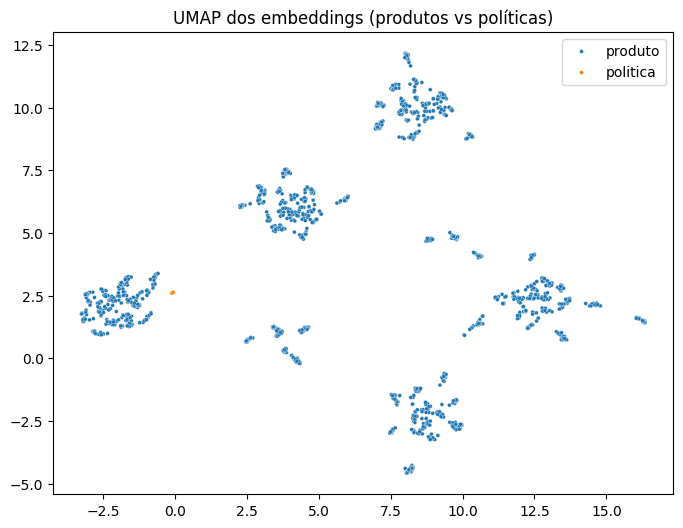

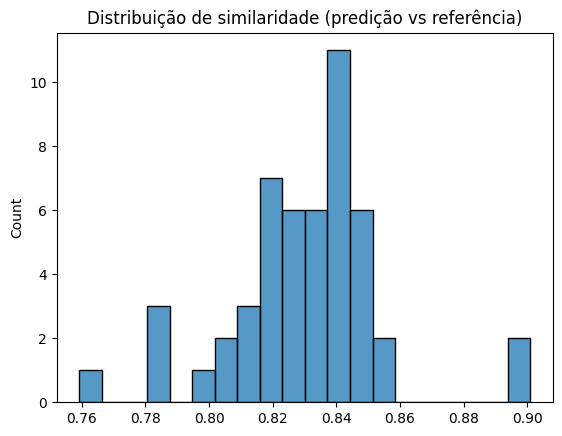

In [ ]:
#@title Visualizações (UMAP, distribuições)
import umap

# UMAP dos embeddings do corpus (amostra para eficiência)
idx_sample = np.random.choice(len(embs), size=min(2000, len(embs)), replace=False)
embs_sample = embs[idx_sample]
labels_sample = [corpus[i]['type'] for i in idx_sample]
reducer = umap.UMAP(random_state=SEED)
xy = reducer.fit_transform(embs_sample)
plt.figure(figsize=(8,6))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=labels_sample, s=8)
plt.title('UMAP dos embeddings (produtos vs políticas)')
plt.show()

# Distribuição de similaridades das top-1 consultas avaliadas
sns.histplot(sims, bins=20)
plt.title('Distribuição de similaridade (predição vs referência)')
plt.show()


## 7.2 Gráfico executivo: Recuperação vs Geração

Comparação lado a lado de Recall/MRR/NDCG (k=5) e BERTScore-F1 para facilitar análise.


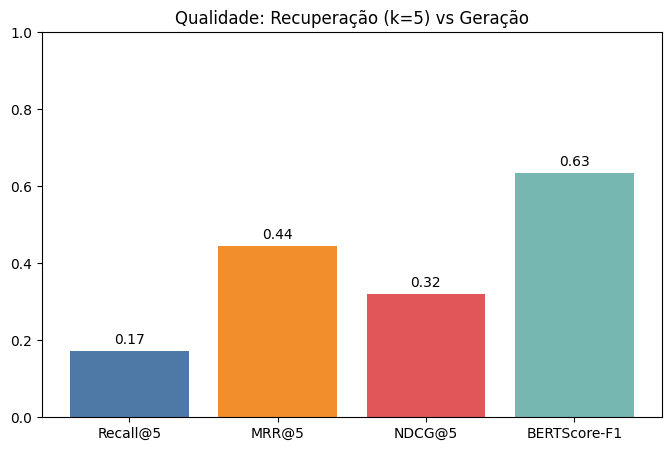

In [ ]:
#@title Gráfico executivo lado a lado
import numpy as np
import matplotlib.pyplot as plt

met_names = ['Recall@5', 'MRR@5', 'NDCG@5', 'BERTScore-F1']
met_values = [
    retrieval_summary.get('recall@5', 0.0),
    retrieval_summary.get('mrr@5', 0.0),
    retrieval_summary.get('ndcg@5', 0.0),
    bert_f1
]

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(met_names, met_values, color=['#4e79a7','#f28e2b','#e15759','#76b7b2'])
ax.set_ylim(0, 1.0)
ax.set_title('Qualidade: Recuperação (k=5) vs Geração')
for b, v in zip(bars, met_values):
    ax.text(b.get_x() + b.get_width()/2, v + 0.02, f"{v:.2f}", ha='center')
plt.show()
